In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import matplotlib.pyplot as plt
import timm
from PIL import Image
import numpy as np
from torchvision import transforms

In [3]:
class ConvNeXtTransformer_concatGAP(nn.Module):
    def __init__(self, num_classes, nhead=8, dim_feedforward=4096, num_transformer_layers=1):
        super(ConvNeXtTransformer_concatGAP, self).__init__()
        self.features = timm.create_model('convnextv2_large.fcmae_ft_in22k_in1k_384', pretrained=True, num_classes=0, global_pool='')
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten(start_dim=2, end_dim=-1)
        d_model = 1536
        self.layer_norm = nn.LayerNorm(d_model)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, dim_feedforward, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_transformer_layers, norm=nn.LayerNorm(d_model), enable_nested_tensor=False)
        self.classifier = nn.Linear(d_model*2, num_classes)
    
    def forward(self, x):
        self.saved_activations = {}
        x = self.features(x)
        # print(x.shape)
        self.saved_activations['convnext'] = x
        x_head = self.gap(x)
        # print(x_head.shape)
        x = self.flatten(x)
        x = x.permute(0, 2, 1)
        x = self.layer_norm(x)
        x = self.transformer_encoder(x)
        x = x.permute(0, 2, 1)
        self.saved_activations['transformer'] = x
        # self.saved_activations['transformer'] = x.permute(0, 2, 1)
        x = torch.mean(x, dim=2)
        x = torch.cat((x_head.view(1, 1536), x), dim=1)
        x = self.classifier(x)
        return x


def load_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(img_path).convert('RGB')
    return transform(img).unsqueeze(0)

def display_heatmap(original_img, heatmap, alpha=0.5):
    """
    显示原始图像与热图的叠加效果。
    参数:
    - original_img: PIL.Image 或 numpy array，原始图像。
    - heatmap: numpy array，热图数据。
    - alpha: float，热图的透明度。
    """
    # 如果original_img是PIL.Image，转换为numpy array
    if isinstance(original_img, Image.Image):
        original_img = np.array(original_img)
    
    # 确保热图的尺寸与原图相同
    heatmap_resized = np.uint8(255 * heatmap)  # 转换为0-255范围
    heatmap_resized = plt.cm.jet(heatmap_resized)[:, :, :3]  # 应用颜色映射
    heatmap_resized = np.uint8(heatmap_resized * 255)  # 再次转换为0-255范围
    heatmap_resized = Image.fromarray(heatmap_resized).resize(original_img.shape[1::-1], Image.BILINEAR)

    # 创建图像显示
    fig, ax = plt.subplots()
    ax.imshow(original_img, alpha=1.0)
    ax.imshow(heatmap_resized, alpha=alpha)  # 叠加热图
    ax.axis('off')  # 不显示坐标轴
    plt.show()


def grad_cam(model, img_tensor, target_layer_key, labels):
    model.eval()
    
    # 确保梯度能够被保存
    gradients = []
    def save_grads_hook(module, grad_input, grad_output):
        # print(grad_output[0].shape)
        gradients.append(grad_output[0])

    # 获取目标层并注册钩子
    if target_layer_key == 'convnext':
        target_layer = model.features
    elif target_layer_key == 'transformer':
        target_layer = model.transformer_encoder
    hook_handle = target_layer.register_full_backward_hook(save_grads_hook)

    # 前向传播并获取指定层的特征
    output = model(img_tensor)
    features = model.saved_activations[target_layer_key]
    # print(features.shape)
    features.retain_grad()  # 显式地保存梯度

    # 反向传播以获取梯度
    model.zero_grad()
    loss_fn = torch.nn.BCEWithLogitsLoss()
    # print(output.shape, labels.shape)
    loss = loss_fn(output, labels)
    loss.backward()

    # 检查梯度是否被捕获
    if not gradients:
        raise ValueError("No gradients were captured - likely an issue with the backward hook.")

    # 使用梯度和特征图计算权重
    if target_layer_key == 'convnext':
        reshaped_gradients = gradients[0].permute(0, 2, 3, 1).clone()
        reshaped_features = features.permute(0, 2, 3, 1).clone()
    elif target_layer_key == 'transformer':
        reshaped_gradients = gradients[0].view(1, 12, 12, 1536)
        reshaped_features = features.reshape(1, 12, 12, 1536)
    
    pooled_gradients = torch.mean(reshaped_gradients, dim=[0, 1, 2])
    # print(pooled_gradients)
    for i in range(reshaped_features.shape[-1]):
        reshaped_features[0, :, :, i] *= pooled_gradients[i]
    heatmap = torch.mean(reshaped_features, dim=3).squeeze()  # 沿通道维度平均
    heatmap = torch.relu(heatmap)  # 应用 ReLU 激活函数
    heatmap /= torch.max(heatmap)
    # print(heatmap.shape)

    # 移除钩子
    hook_handle.remove()

    return heatmap.detach().cpu().numpy()


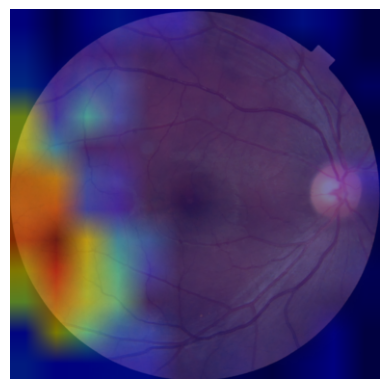

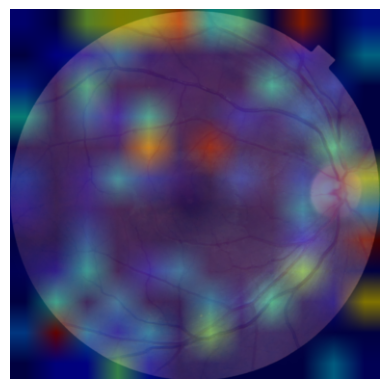

In [10]:
#### 1 label (654.png)
model_path = './saved_models/myconvnext_2layer_concatGAP_my_remedial_10_sm.pt'
model = ConvNeXtTransformer_concatGAP(num_classes=20, num_transformer_layers=2)

model_state_dict = torch.load(model_path)
model.load_state_dict(model_state_dict)
img_tensor = load_image('./data/fundus/MuReD/images/images/654.png')
labels = torch.tensor([0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]).unsqueeze(0).float()


convnext_heatmap = grad_cam(model, img_tensor, 'convnext', labels)
transformer_heatmap = grad_cam(model, img_tensor, 'transformer', labels)

display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), convnext_heatmap)
display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), transformer_heatmap)

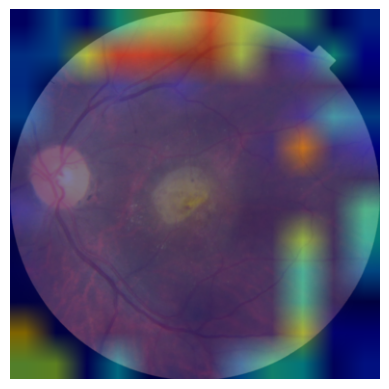

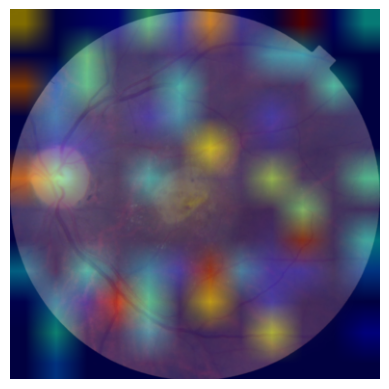

In [8]:
#### 2 label (188.png)
model_path = './saved_models/myconvnext_2layer_concatGAP_my_remedial_10_sm.pt'
model = ConvNeXtTransformer_concatGAP(num_classes=20, num_transformer_layers=2)

model_state_dict = torch.load(model_path)
model.load_state_dict(model_state_dict)
img_tensor = load_image('./data/fundus/MuReD/images/images/188.png')
labels = torch.tensor([0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).unsqueeze(0).float()


convnext_heatmap = grad_cam(model, img_tensor, 'convnext', labels)
transformer_heatmap = grad_cam(model, img_tensor, 'transformer', labels)

display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), convnext_heatmap)
display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), transformer_heatmap)

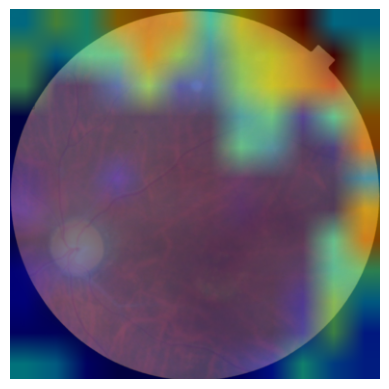

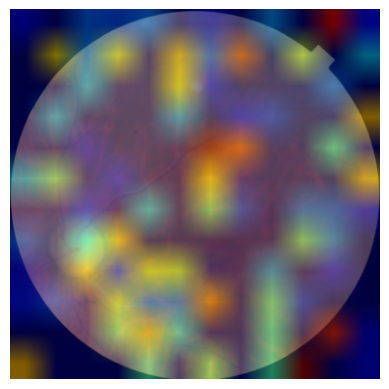

In [9]:
#### 3 label (146.png)
model_path = './saved_models/myconvnext_2layer_concatGAP_my_remedial_10_sm.pt'
model = ConvNeXtTransformer_concatGAP(num_classes=20, num_transformer_layers=2)

model_state_dict = torch.load(model_path)
model.load_state_dict(model_state_dict)
img_tensor = load_image('./data/fundus/MuReD/images/images/146.png')
labels = torch.tensor([0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]).unsqueeze(0).float()


convnext_heatmap = grad_cam(model, img_tensor, 'convnext', labels)
transformer_heatmap = grad_cam(model, img_tensor, 'transformer', labels)

display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), convnext_heatmap)
display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), transformer_heatmap)

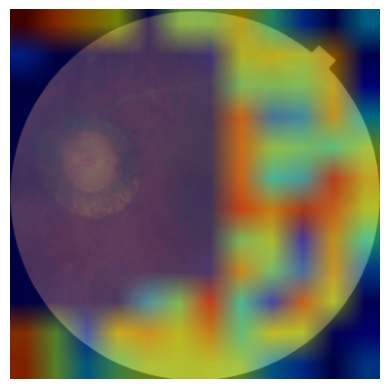

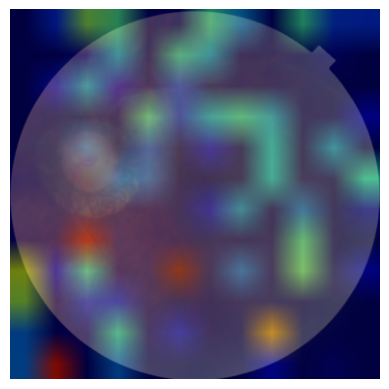

In [11]:
#### 3 label (980.png)
model_path = './saved_models/myconvnext_2layer_concatGAP_my_remedial_10_sm.pt'
model = ConvNeXtTransformer_concatGAP(num_classes=20, num_transformer_layers=2)

model_state_dict = torch.load(model_path)
model.load_state_dict(model_state_dict)
img_tensor = load_image('./data/fundus/MuReD/images/images/980.png')
labels = torch.tensor([0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0]).unsqueeze(0).float()


convnext_heatmap = grad_cam(model, img_tensor, 'convnext', labels)
transformer_heatmap = grad_cam(model, img_tensor, 'transformer', labels)

display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), convnext_heatmap)
display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), transformer_heatmap)